## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

_Van der Pol intermittancy_

The `van_der_pol_intermittency.dat` feeds the model with the dynamics of the Van der Pol Oscillator

In [3]:
data = np.genfromtxt('datasets/van_der_pol_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

1.0
1        -0.000014
2        -0.000029
3        -0.000045
4        -0.000061
5        -0.000077
            ...   
139867    0.000662
139868    0.000661
139869    0.000661
139870    0.000660
139871    0.000659
Name: 1, Length: 139871, dtype: float64
2        -2.122449e-06
3        -2.206735e-06
4        -2.293673e-06
5        -2.382653e-06
6        -2.473878e-06
              ...     
139867   -9.530612e-08
139868   -9.571429e-08
139869   -9.571429e-08
139870   -9.571429e-08
139871   -9.612245e-08
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_EL NINO_

In [5]:
data = pd.read_csv("datasets/elnino.csv")
training_set = data.iloc[:,1]
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


In [6]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0        -0.000014
1        -0.000029
2        -0.000045
3        -0.000061
4        -0.000077
            ...   
139866    0.000662
139867    0.000661
139868    0.000661
139869    0.000660
139870    0.000659
Name: 1, Length: 139871, dtype: float64
0        -2.122449e-06
1        -2.206735e-06
2        -2.293673e-06
3        -2.382653e-06
4        -2.473878e-06
              ...     
139865   -9.530612e-08
139866   -9.571429e-08
139867   -9.571429e-08
139868   -9.571429e-08
139869   -9.612245e-08
Name: 1, Length: 139870, dtype: float64


In [7]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Van der Pol Oscillator_)

<AxesSubplot:>

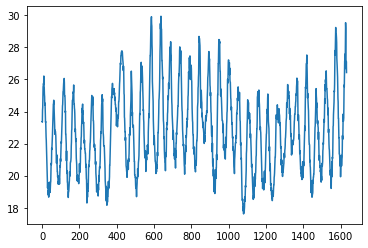

In [8]:
mu = 4
L = df.iloc[:, 2] - mu * (df.iloc[:, 1] - (df.iloc[:, 0]**2 * df.iloc[:, 1]) - (1/mu) * df.iloc[:, 0])
L.plot()

## Preprocessing the data into supervised learning

In [9]:
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg    

In [10]:
dat = Supervised(df.values, n_in = 10, n_out = 52)
dat.columns

Index(['var1(t-10)', 'var2(t-10)', 'var3(t-10)', 'var1(t-9)', 'var2(t-9)',
       'var3(t-9)', 'var1(t-8)', 'var2(t-8)', 'var3(t-8)', 'var1(t-7)',
       ...
       'var3(t+48)', 'var1(t+49)', 'var2(t+49)', 'var3(t+49)', 'var1(t+50)',
       'var2(t+50)', 'var3(t+50)', 'var1(t+51)', 'var2(t+51)', 'var3(t+51)'],
      dtype='object', length=186)

In [11]:
data = Supervised(df.values, n_in = 10, n_out = 52)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)#,18,19
print(data.head())
print(data.columns)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        23.4       23.4       24.2       24.4       25.1       25.8   
11        23.4       24.2       24.4       25.1       25.8       25.9   
12        24.2       24.4       25.1       25.8       25.9       26.1   
13        24.4       25.1       25.8       25.9       26.1       26.1   
14        25.1       25.8       25.9       26.1       26.1       26.7   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  ...    var3(t+48)  var1(t+49)  \
10       25.9       26.1       26.1       26.7  ...  1.755102e-08        26.5   
11       26.1       26.1       26.7       26.1  ...  2.571429e-08        26.5   
12       26.1       26.7       26.1       26.1  ...  3.306122e-08        26.5   
13       26.7       26.1       26.1       25.7  ...  3.897959e-08        26.8   
14       26.1       26.1       25.7       25.6  ...  4.469388e-08        26.6   

    var2(t+49)    var3(t+49)  var1(t+50)  var2(t+50)    var3(t+50)  \
10  

## Train and Test Split

In [12]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_1 = np.array(data[0:train_size])
test_1 = np.array(data[train_size:len(data)])
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_1)
test = scaler.transform(test_1)
trainY = train[:,-9:]
trainX = train[:,:-9]
testY = test[:,-9:]
testX = test[:,:-9]
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1257, 1, 157) (1257, 9) (315, 1, 157) (315, 9)


## Defining the Physical Loss

In [13]:
mu = tf.Variable(4, name="mu", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error(y_true[:, 2] - mu * (y_true[:, 1] - (y_true[:, 0]**2 * y_true[:, 1]) - (1/mu) * y_true[:, 0]), y_pred[:, 2] - mu * (y_pred[:, 1] - (y_pred[:, 0]**2 * y_pred[:, 1]) - (1/mu) * y_pred[:, 0]))


def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] - mu * ((y_pred[1:-1]-y_pred[:-2]) - (y_pred[:-2]**2 * (y_pred[1:-1]-y_pred[:-2])) - (1/mu) * y_pred[:-2])
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] - mu * ((y_real[1:-1]-y_real[:-2]) - (y_real[:-2]**2 * (y_real[1:-1]-y_real[:-2])) - (1/mu) * y_real[:-2])
    return(mean_absolute_error(pred, real))

## Model (Without Monte Carlo Dropout)

In [14]:
mu = tf.Variable(4, name="mu", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(
        y_pred[:, 2] - mu * (y_pred[:, 1] - (y_pred[:, 0]**2 * y_pred[:, 1]) - (1/mu) * y_pred[:, 0]))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(0.8*trainX.shape[0])], trainY[:int(0.8*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(0.8*trainX.shape[0]):trainX.shape[0]], trainY[int(0.8*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
16/16 [==============================] - 3s 34ms/step - loss: 0.1134 - val_loss: 0.0292
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0719 - val_loss: 0.1165
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0652 - val_loss: 0.0320
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0365 - val_loss: 0.0255
Epoch 5/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0253 - val_loss: 0.0235
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0217 - val_loss: 0.0148
Epoch 7/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0098
Epoch 8/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.0084
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0098
Epoch 10/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0094
Epoch 11

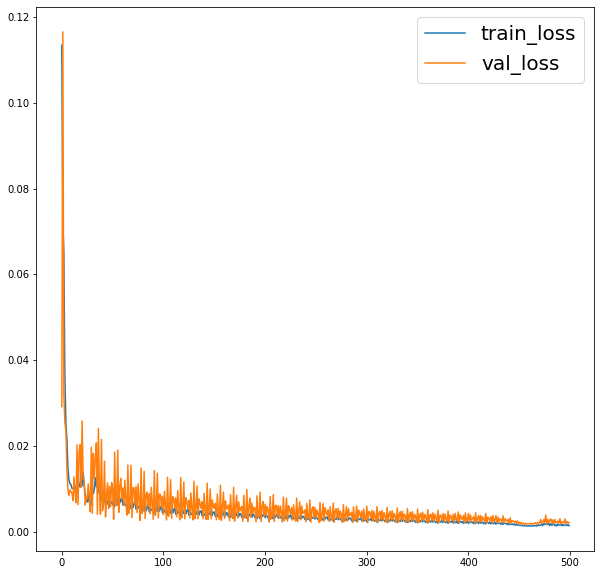

In [15]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (Without Monte Carlo Dropout)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_without_mc = testX
textY_without_mc = testY
yhat_without_mc = model.predict(textX_without_mc)
print(yhat_without_mc.shape)
textX_without_mc = textX_without_mc.reshape((textX_without_mc.shape[0], textX_without_mc.shape[2]))
print(textX_without_mc.shape)
inv_yhat_without_mc = np.concatenate((textX_without_mc, yhat_without_mc), axis=1)
inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc)
inv_yhat1_without_mc = inv_yhat_without_mc[:, -3:]
inv_yhat_without_mc = inv_yhat_without_mc[:, -3]
inv_y_without_mc = np.concatenate((textX_without_mc, textY_without_mc), axis=1)
inv_y_without_mc = scaler.inverse_transform(inv_y_without_mc)
inv_y1_without_mc = inv_y_without_mc[:, -3:]
inv_y_without_mc = inv_y_without_mc[:, -3]
rmse_without_mc = np.sqrt(mean_squared_error(inv_y_without_mc, inv_yhat_without_mc))
mae_without_mc = mean_absolute_error(inv_y_without_mc, inv_yhat_without_mc)
print('Test RMSE: %.3f' % rmse_without_mc)
print('Test MAE: %.3f' % mae_without_mc)

10/10 [==============================] - 1s 2ms/step
(315, 9)
(315, 157)
Test RMSE: 6.348
Test MAE: 6.097


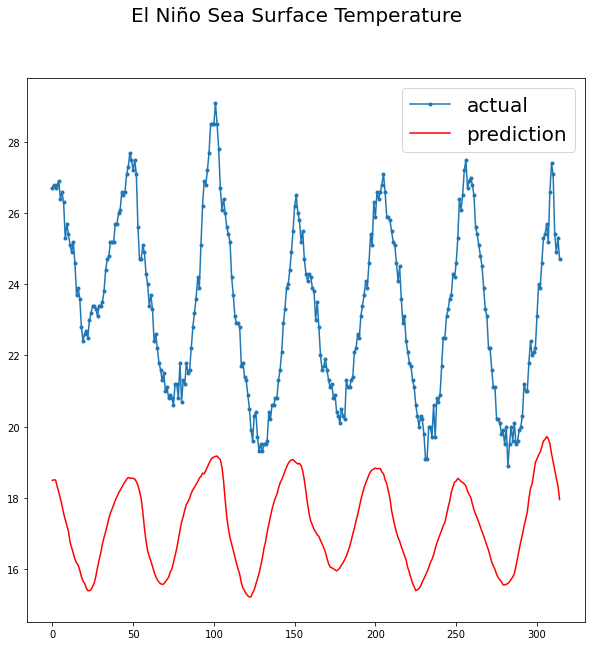

In [17]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_without_mc, marker='.', label="actual")
plt.plot(inv_yhat_without_mc, 'r', label="prediction")
plt.suptitle('El Niño Sea Surface Temperature', fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Model (With Monte Carlo Dropout)

In [18]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [19]:
mu = tf.Variable(4, name="mu", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(
        y_pred[:, 2] - mu * (y_pred[:, 1] - (y_pred[:, 0]**2 * y_pred[:, 1]) - (1/mu) * y_pred[:, 0]))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.add(MCDropout(0.4))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(0.8*trainX.shape[0])], trainY[:int(0.8*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(0.8*trainX.shape[0]):trainX.shape[0]], trainY[int(0.8*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
16/16 [==============================] - 3s 38ms/step - loss: 0.2087 - val_loss: 0.1258
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1370 - val_loss: 0.1550
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1484 - val_loss: 0.1310
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1363 - val_loss: 0.1778
Epoch 5/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1507 - val_loss: 0.1174
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1538 - val_loss: 0.2449
Epoch 7/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1576 - val_loss: 0.1646
Epoch 8/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1489 - val_loss: 0.1058
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1280 - val_loss: 0.1194
Epoch 10/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1378 - val_loss: 0.1219
Epoch 11

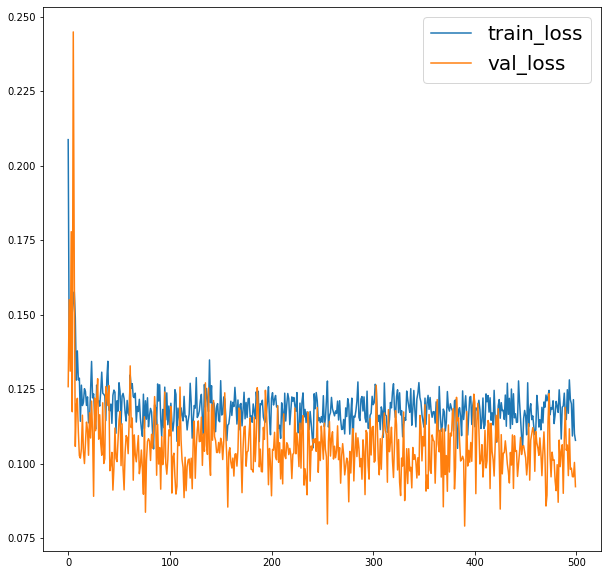

In [20]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (With Monte Carlo Dropout)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_with_mc = testX
textY_with_mc = testY
yhat_with_mc = model.predict(textX_with_mc)
print(yhat_with_mc.shape)
textX_with_mc = testX.reshape((textX_with_mc.shape[0], textX_with_mc.shape[2]))
print(textX_with_mc.shape)
inv_yhat_with_mc = np.concatenate((textX_with_mc, yhat_with_mc), axis=1)
inv_yhat_with_mc = scaler.inverse_transform(inv_yhat_with_mc)
inv_yhat1_with_mc = inv_yhat_with_mc[:, -3:]
inv_yhat_with_mc = inv_yhat_with_mc[:, -3]
inv_y_with_mc = np.concatenate((textX_with_mc, textY_with_mc), axis=1)
inv_y_with_mc = scaler.inverse_transform(inv_y_with_mc)
inv_y1_with_mc = inv_y_with_mc[:, -3:]
inv_y_with_mc = inv_y_with_mc[:, -3]
rmse_with_mc = np.sqrt(mean_squared_error(inv_y_with_mc, inv_yhat_with_mc))
mae_with_mc = mean_absolute_error(inv_y_with_mc, inv_yhat_with_mc)
print('Test RMSE: %.3f' % rmse_with_mc)
print('Test MAE: %.3f' % mae_with_mc)

10/10 [==============================] - 1s 2ms/step
(315, 9)
(315, 157)
Test RMSE: 5.847
Test MAE: 5.403


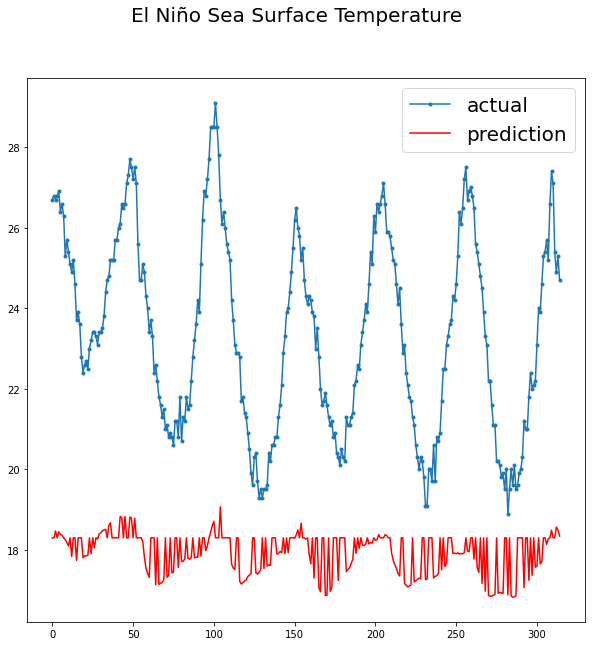

In [22]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_with_mc, marker='.', label="actual")
plt.plot(inv_yhat_with_mc, 'r', label="prediction")
plt.suptitle('El Niño Sea Surface Temperature', fontsize=20)
plt.legend(fontsize=20)
plt.show()